In [1]:
# Train UrbanSound8K model
#
import sys
sys.path.append('../..')
from lib_train import *
import matplotlib.pyplot as plt
%matplotlib inline

{'sampling_rate': 44100, 'duration': 1, 'hop_length': 347, 'fmin': 20, 'fmax': 22050, 'n_mels': 128, 'n_fft': 2560, 'model': 'mobilenetv2', 'labels': ['dog_bark', 'children_playing', 'car_horn', 'air_conditioner', 'street_music', 'gun_shot', 'siren', 'engine_idling', 'jackhammer', 'drilling'], 'folder': PosixPath('.'), 'n_fold': 1, 'valid_limit': None, 'random_state': 42, 'test_size': 0.01, 'samples_per_file': 5, 'batch_size': 32, 'learning_rate': 0.0001, 'metric_save_ckpt': 'val_acc', 'epochs': 100, 'verbose': 2, 'best_weight_file': 'best_model_weight.h5', 'rt_process_count': 1, 'rt_oversamples': 10, 'pred_ensembles': 10, 'runtime_model_file': 'model/mobilenetv2_fsd2018_41cls.pb', 'label2int': {'dog_bark': 0, 'children_playing': 1, 'car_horn': 2, 'air_conditioner': 3, 'street_music': 4, 'gun_shot': 5, 'siren': 6, 'engine_idling': 7, 'jackhammer': 8, 'drilling': 9}, 'num_classes': 10, 'samples': 44100, 'rt_chunk_samples': 4410, 'mels_onestep_samples': 4410, 'mels_convert_samples': 4851

Using TensorFlow backend.


In [ ]:
sys.path.append('../../../project-ml')
from projectml import ProjectML

def project_setup(pj):
    """Setup for entire training session."""
    pj.vars.holdout_fold = 0
    pj.results.metrics = []
    pj.prms.epochs = 100

def cycle_update_parameter(pj):
    """Update parameter for current fold."""
    print('== Fold {} =='.format(pj.vars.holdout_fold))
    pj.prms.best_weight_file = 'model_weight_%d.h5' % pj.vars.holdout_fold

def cycle_setup_data(pj):
    """Load data for current fold."""
    X_train = []
    y_train = []
    for fold in range(pj.dataset_policy.cv_folds):
        if pj.vars.holdout_fold == fold:
            continue
        X_train.extend(np.load('X_fold%d.npy' % (fold+1)))
        y_train.extend(np.load('y_fold%d.npy' % (fold+1)))
    pj.vars.X_train = np.array(X_train)
    pj.vars.X_valid = np.load('X_fold%d.npy' % (pj.vars.holdout_fold+1))
    pj.vars.y_train = keras.utils.to_categorical(y_train)
    pj.vars.y_valid = keras.utils.to_categorical(np.load('y_fold%d.npy' % (pj.vars.holdout_fold+1)))
    # Normalize
    samplewise_normalize_audio_X(pj.vars.X_train)
    samplewise_normalize_audio_X(pj.vars.X_valid)

def cycle_train_model(pj):
    """Train model for current fold."""
    model = create_model(pj.prms)
    _, model, plain_datagen = train_model(pj.prms, fold=0,
                                          dataset=[pj.vars.X_train,
                                                   pj.vars.y_train,
                                                   pj.vars.X_valid,
                                                   pj.vars.y_valid],
                                          model=model)
    pj.vars.training_vars = [model, plain_datagen]

def cycle_evaluate(pj):
    """Evaluate a metric."""
    model, plain_datagen = pj.vars.training_vars
    model.load_weights(pj.prms.best_weight_file)
    pj.results.metrics.append(evaluate_model(pj.prms, model,
                                             pj.vars.X_valid, pj.vars.y_valid))

def cycle_update_policy(pj):
    """Check for completion - this is policy for this app."""
    pj.vars.holdout_fold += 1
    if pj.vars.holdout_fold >= pj.dataset_policy.cv_folds:
        return False # finished all folds, no need to continue
    return True # continue cycles

def summarize_total_performance(pj):
    """Summarize total performance."""
    df = summarize_metrics_history(pj.results.metrics)
    print('Final acc = ', df.accuracy.mean())

#
project = ProjectML(
    setup_fn=project_setup,
    cycle_update_parameter_fn=cycle_update_parameter,
    cycle_setup_data_fn=cycle_setup_data,
    cycle_train_model_fn=cycle_train_model,
    cycle_evaluate_fn=cycle_evaluate,
    cycle_update_policy_fn=cycle_update_policy,
    summarize_total_fn=summarize_total_performance,
    dataset_policy={'cv_folds': 10},
    parameters=conf
)

project.run()

Dataset policy: {'cv_folds': 10}
Training policy: {}
Parameters: {'sampling_rate': 44100, 'duration': 1, 'hop_length': 347, 'fmin': 20, 'fmax': 22050, 'n_mels': 128, 'n_fft': 2560, 'labels': ['dog_bark', 'children_playing', 'car_horn', 'air_conditioner', 'street_music', 'gun_shot', 'siren', 'engine_idling', 'jackhammer', 'drilling'], 'folder': PosixPath('.'), 'n_fold': 1, 'valid_limit': None, 'random_state': 42, 'test_size': 0.01, 'samples_per_file': 5, 'batch_size': 32, 'learning_rate': 0.0001, 'metric_save_ckpt': 'val_acc', 'epochs': 100, 'verbose': 2, 'best_weight_file': 'best_model_weight.h5', 'rt_process_count': 1, 'rt_oversamples': 10, 'pred_ensembles': 10, 'runtime_model_file': 'model/mobilenetv2_fsd2018_41cls.pb', 'label2int': {'dog_bark': 0, 'children_playing': 1, 'car_horn': 2, 'air_conditioner': 3, 'street_music': 4, 'gun_shot': 5, 'siren': 6, 'engine_idling': 7, 'jackhammer': 8, 'drilling': 9}, 'num_classes': 10, 'samples': 44100, 'rt_chunk_samples': 4410, 'mels_onestep_sam

Epoch 1/100
 - 71s - loss: 2.1208 - acc: 0.2290 - val_loss: 2.0516 - val_acc: 0.2568

Epoch 00001: val_acc improved from -inf to 0.25682, saving model to model_weight_0.h5
Epoch 2/100
 - 65s - loss: 1.9310 - acc: 0.3404 - val_loss: 1.9419 - val_acc: 0.3535

Epoch 00002: val_acc improved from 0.25682 to 0.35349, saving model to model_weight_0.h5
Epoch 3/100
 - 66s - loss: 1.7866 - acc: 0.4235 - val_loss: 1.6856 - val_acc: 0.4167

Epoch 00003: val_acc improved from 0.35349 to 0.41672, saving model to model_weight_0.h5
Epoch 4/100
 - 65s - loss: 1.6739 - acc: 0.4862 - val_loss: 1.7054 - val_acc: 0.4616

Epoch 00004: val_acc improved from 0.41672 to 0.46163, saving model to model_weight_0.h5
Epoch 5/100
 - 66s - loss: 1.5876 - acc: 0.5368 - val_loss: 1.5474 - val_acc: 0.4914

Epoch 00005: val_acc improved from 0.46163 to 0.49141, saving model to model_weight_0.h5
Epoch 6/100
 - 65s - loss: 1.5019 - acc: 0.5820 - val_loss: 1.5465 - val_acc: 0.4877

Epoch 00006: val_acc did not improve from 


Epoch 00057: val_acc did not improve from 0.66300
Epoch 58/100
 - 66s - loss: 0.9383 - acc: 0.8470 - val_loss: 1.2218 - val_acc: 0.6309

Epoch 00058: val_acc did not improve from 0.66300
Epoch 59/100
 - 65s - loss: 0.9408 - acc: 0.8491 - val_loss: 1.3819 - val_acc: 0.6376

Epoch 00059: val_acc did not improve from 0.66300
Epoch 60/100
 - 65s - loss: 0.9339 - acc: 0.8526 - val_loss: 1.1708 - val_acc: 0.6458

Epoch 00060: val_acc did not improve from 0.66300
Epoch 61/100
 - 66s - loss: 0.9365 - acc: 0.8465 - val_loss: 1.3503 - val_acc: 0.6135

Epoch 00061: val_acc did not improve from 0.66300
Epoch 62/100
 - 66s - loss: 0.9320 - acc: 0.8486 - val_loss: 1.3615 - val_acc: 0.6158

Epoch 00062: val_acc did not improve from 0.66300
Epoch 63/100
 - 66s - loss: 0.9288 - acc: 0.8550 - val_loss: 1.4720 - val_acc: 0.6156

Epoch 00063: val_acc did not improve from 0.66300
Epoch 64/100
 - 65s - loss: 0.9285 - acc: 0.8527 - val_loss: 1.3322 - val_acc: 0.6277

Epoch 00064: val_acc did not improve fro

Epoch 1/100
 - 72s - loss: 2.1328 - acc: 0.2228 - val_loss: 2.4789 - val_acc: 0.2133

Epoch 00001: val_acc improved from -inf to 0.21329, saving model to model_weight_1.h5
Epoch 2/100
 - 67s - loss: 1.9362 - acc: 0.3309 - val_loss: 2.3275 - val_acc: 0.2700

Epoch 00002: val_acc improved from 0.21329 to 0.27005, saving model to model_weight_1.h5
Epoch 3/100
 - 67s - loss: 1.8299 - acc: 0.4035 - val_loss: 2.3911 - val_acc: 0.2662

Epoch 00003: val_acc did not improve from 0.27005
Epoch 4/100
 - 67s - loss: 1.7364 - acc: 0.4571 - val_loss: 2.6381 - val_acc: 0.2209

Epoch 00004: val_acc did not improve from 0.27005
Epoch 5/100
 - 67s - loss: 1.6437 - acc: 0.5056 - val_loss: 2.1748 - val_acc: 0.3516

Epoch 00005: val_acc improved from 0.27005 to 0.35158, saving model to model_weight_1.h5
Epoch 6/100
 - 67s - loss: 1.5505 - acc: 0.5549 - val_loss: 1.8407 - val_acc: 0.4221

Epoch 00006: val_acc improved from 0.35158 to 0.42207, saving model to model_weight_1.h5
Epoch 7/100
 - 67s - loss: 1.47


Epoch 00057: val_acc did not improve from 0.66059
Epoch 58/100
 - 67s - loss: 0.9409 - acc: 0.8466 - val_loss: 1.1971 - val_acc: 0.6441

Epoch 00058: val_acc did not improve from 0.66059
Epoch 59/100
 - 67s - loss: 0.9335 - acc: 0.8481 - val_loss: 1.3137 - val_acc: 0.5838

Epoch 00059: val_acc did not improve from 0.66059
Epoch 60/100
 - 67s - loss: 0.9314 - acc: 0.8484 - val_loss: 1.1690 - val_acc: 0.6297

Epoch 00060: val_acc did not improve from 0.66059
Epoch 61/100
 - 67s - loss: 0.9234 - acc: 0.8526 - val_loss: 1.0357 - val_acc: 0.6480

Epoch 00061: val_acc did not improve from 0.66059
Epoch 62/100
 - 67s - loss: 0.9251 - acc: 0.8489 - val_loss: 1.1751 - val_acc: 0.5995

Epoch 00062: val_acc did not improve from 0.66059
Epoch 63/100
 - 67s - loss: 0.9231 - acc: 0.8536 - val_loss: 1.2292 - val_acc: 0.5986

Epoch 00063: val_acc did not improve from 0.66059
Epoch 64/100
 - 67s - loss: 0.9214 - acc: 0.8519 - val_loss: 1.3823 - val_acc: 0.6068

Epoch 00064: val_acc did not improve fro

Epoch 1/100
 - 72s - loss: 2.0993 - acc: 0.2439 - val_loss: 2.2669 - val_acc: 0.2783

Epoch 00001: val_acc improved from -inf to 0.27827, saving model to model_weight_2.h5
Epoch 2/100
 - 67s - loss: 1.8841 - acc: 0.3627 - val_loss: 2.3078 - val_acc: 0.3319

Epoch 00002: val_acc improved from 0.27827 to 0.33189, saving model to model_weight_2.h5
Epoch 3/100
 - 67s - loss: 1.7535 - acc: 0.4395 - val_loss: 2.8383 - val_acc: 0.2504

Epoch 00003: val_acc did not improve from 0.33189
Epoch 4/100
 - 67s - loss: 1.6339 - acc: 0.5131 - val_loss: 1.9614 - val_acc: 0.3559

Epoch 00004: val_acc improved from 0.33189 to 0.35589, saving model to model_weight_2.h5
Epoch 5/100
 - 67s - loss: 1.5549 - acc: 0.5557 - val_loss: 1.7745 - val_acc: 0.4266

Epoch 00005: val_acc improved from 0.35589 to 0.42659, saving model to model_weight_2.h5
Epoch 6/100
 - 67s - loss: 1.4919 - acc: 0.5904 - val_loss: 1.5665 - val_acc: 0.4662

Epoch 00006: val_acc improved from 0.42659 to 0.46616, saving model to model_weig


Epoch 00056: val_acc did not improve from 0.63676
Epoch 57/100
 - 68s - loss: 0.9556 - acc: 0.8380 - val_loss: 1.2778 - val_acc: 0.6169

Epoch 00057: val_acc did not improve from 0.63676
Epoch 58/100
 - 67s - loss: 0.9513 - acc: 0.8419 - val_loss: 1.3467 - val_acc: 0.6084

Epoch 00058: val_acc did not improve from 0.63676
Epoch 59/100
 - 67s - loss: 0.9450 - acc: 0.8451 - val_loss: 1.3685 - val_acc: 0.5853

Epoch 00059: val_acc did not improve from 0.63676
Epoch 60/100
 - 67s - loss: 0.9445 - acc: 0.8443 - val_loss: 1.3749 - val_acc: 0.5877

Epoch 00060: val_acc did not improve from 0.63676
Epoch 61/100
 - 68s - loss: 0.9390 - acc: 0.8475 - val_loss: 1.2808 - val_acc: 0.6108

Epoch 00061: val_acc did not improve from 0.63676
Epoch 62/100
 - 67s - loss: 0.9364 - acc: 0.8477 - val_loss: 1.3020 - val_acc: 0.6409

Epoch 00062: val_acc improved from 0.63676 to 0.64086, saving model to model_weight_2.h5
Epoch 63/100
 - 68s - loss: 0.9370 - acc: 0.8480 - val_loss: 1.2570 - val_acc: 0.6192

E

Epoch 1/100
 - 73s - loss: 2.0897 - acc: 0.2431 - val_loss: 2.1169 - val_acc: 0.2184

Epoch 00001: val_acc improved from -inf to 0.21838, saving model to model_weight_3.h5
Epoch 2/100
 - 69s - loss: 1.9207 - acc: 0.3447 - val_loss: 2.1529 - val_acc: 0.2477

Epoch 00002: val_acc improved from 0.21838 to 0.24768, saving model to model_weight_3.h5
Epoch 3/100
 - 69s - loss: 1.7791 - acc: 0.4352 - val_loss: 1.9853 - val_acc: 0.3745

Epoch 00003: val_acc improved from 0.24768 to 0.37455, saving model to model_weight_3.h5
Epoch 4/100
 - 68s - loss: 1.6497 - acc: 0.5087 - val_loss: 1.7916 - val_acc: 0.3947

Epoch 00004: val_acc improved from 0.37455 to 0.39475, saving model to model_weight_3.h5
Epoch 5/100
 - 69s - loss: 1.5512 - acc: 0.5575 - val_loss: 1.7513 - val_acc: 0.3885

Epoch 00005: val_acc did not improve from 0.39475
Epoch 6/100
 - 69s - loss: 1.4809 - acc: 0.5975 - val_loss: 1.9857 - val_acc: 0.3661

Epoch 00006: val_acc did not improve from 0.39475
Epoch 7/100
 - 69s - loss: 1.42


Epoch 00032: val_acc did not improve from 0.74936
Epoch 33/100
 - 72s - loss: 1.0447 - acc: 0.8040 - val_loss: 0.9602 - val_acc: 0.7111

Epoch 00033: val_acc did not improve from 0.74936
Epoch 34/100
 - 72s - loss: 1.0437 - acc: 0.8047 - val_loss: 0.8094 - val_acc: 0.7603

Epoch 00034: val_acc improved from 0.74936 to 0.76026, saving model to model_weight_4.h5
Epoch 35/100
 - 72s - loss: 1.0377 - acc: 0.8113 - val_loss: 0.8266 - val_acc: 0.7474

Epoch 00035: val_acc did not improve from 0.76026
Epoch 36/100
 - 72s - loss: 1.0314 - acc: 0.8126 - val_loss: 0.8377 - val_acc: 0.7415

Epoch 00036: val_acc did not improve from 0.76026
Epoch 37/100
 - 72s - loss: 1.0251 - acc: 0.8149 - val_loss: 0.8402 - val_acc: 0.7209

Epoch 00037: val_acc did not improve from 0.76026
Epoch 38/100
 - 72s - loss: 1.0191 - acc: 0.8165 - val_loss: 0.7792 - val_acc: 0.7472

Epoch 00038: val_acc did not improve from 0.76026
Epoch 39/100
 - 72s - loss: 1.0154 - acc: 0.8198 - val_loss: 0.9020 - val_acc: 0.7312

E


Epoch 00092: val_acc did not improve from 0.76026
Epoch 93/100
 - 72s - loss: 0.8887 - acc: 0.8611 - val_loss: 0.9489 - val_acc: 0.7226

Epoch 00093: val_acc did not improve from 0.76026
Epoch 94/100
 - 72s - loss: 0.8856 - acc: 0.8634 - val_loss: 0.8945 - val_acc: 0.7212

Epoch 00094: val_acc did not improve from 0.76026
Epoch 95/100
 - 72s - loss: 0.8892 - acc: 0.8601 - val_loss: 0.9381 - val_acc: 0.7047

Epoch 00095: val_acc did not improve from 0.76026
Epoch 96/100
 - 72s - loss: 0.8795 - acc: 0.8658 - val_loss: 0.8488 - val_acc: 0.7444

Epoch 00096: val_acc did not improve from 0.76026
Epoch 97/100
 - 72s - loss: 0.8824 - acc: 0.8659 - val_loss: 0.9167 - val_acc: 0.6940

Epoch 00097: val_acc did not improve from 0.76026
Epoch 98/100
 - 72s - loss: 0.8720 - acc: 0.8687 - val_loss: 0.9376 - val_acc: 0.7064

Epoch 00098: val_acc did not improve from 0.76026
Epoch 99/100
 - 72s - loss: 0.8790 - acc: 0.8663 - val_loss: 0.9512 - val_acc: 0.6863

Epoch 00099: val_acc did not improve fro

Epoch 1/100
 - 79s - loss: 2.1073 - acc: 0.2427 - val_loss: 2.2216 - val_acc: 0.2488

Epoch 00001: val_acc improved from -inf to 0.24885, saving model to model_weight_5.h5
Epoch 2/100
 - 74s - loss: 1.9130 - acc: 0.3509 - val_loss: 2.2482 - val_acc: 0.2768

Epoch 00002: val_acc improved from 0.24885 to 0.27679, saving model to model_weight_5.h5
Epoch 3/100
 - 74s - loss: 1.7660 - acc: 0.4360 - val_loss: 2.1474 - val_acc: 0.3252

Epoch 00003: val_acc improved from 0.27679 to 0.32515, saving model to model_weight_5.h5
Epoch 4/100
 - 74s - loss: 1.6490 - acc: 0.5037 - val_loss: 1.9943 - val_acc: 0.3959

Epoch 00004: val_acc improved from 0.32515 to 0.39587, saving model to model_weight_5.h5
Epoch 5/100
 - 74s - loss: 1.5518 - acc: 0.5528 - val_loss: 2.1913 - val_acc: 0.3689

Epoch 00005: val_acc did not improve from 0.39587
Epoch 6/100
 - 74s - loss: 1.4847 - acc: 0.5914 - val_loss: 1.8177 - val_acc: 0.4476

Epoch 00006: val_acc improved from 0.39587 to 0.44763, saving model to model_weig

 - 74s - loss: 0.9411 - acc: 0.8450 - val_loss: 1.2541 - val_acc: 0.6330

Epoch 00057: val_acc did not improve from 0.69623
Epoch 58/100
 - 74s - loss: 0.9412 - acc: 0.8475 - val_loss: 1.1338 - val_acc: 0.6299

Epoch 00058: val_acc did not improve from 0.69623
Epoch 59/100
 - 74s - loss: 0.9369 - acc: 0.8435 - val_loss: 1.2280 - val_acc: 0.5908

Epoch 00059: val_acc did not improve from 0.69623
Epoch 60/100
 - 74s - loss: 0.9432 - acc: 0.8461 - val_loss: 1.2777 - val_acc: 0.5903

Epoch 00060: val_acc did not improve from 0.69623
Epoch 61/100
 - 74s - loss: 0.9319 - acc: 0.8458 - val_loss: 1.3232 - val_acc: 0.6204

Epoch 00061: val_acc did not improve from 0.69623
Epoch 62/100
 - 74s - loss: 0.9283 - acc: 0.8481 - val_loss: 1.1790 - val_acc: 0.6207

Epoch 00062: val_acc did not improve from 0.69623
Epoch 63/100
 - 74s - loss: 0.9286 - acc: 0.8485 - val_loss: 1.2264 - val_acc: 0.6255

Epoch 00063: val_acc did not improve from 0.69623
Epoch 64/100
 - 74s - loss: 0.9287 - acc: 0.8484 - val

Epoch 1/100
 - 80s - loss: 2.0922 - acc: 0.2443 - val_loss: 2.3655 - val_acc: 0.2406

Epoch 00001: val_acc improved from -inf to 0.24057, saving model to model_weight_6.h5
Epoch 2/100
 - 75s - loss: 1.8601 - acc: 0.3765 - val_loss: 2.5546 - val_acc: 0.2632

Epoch 00002: val_acc improved from 0.24057 to 0.26325, saving model to model_weight_6.h5
Epoch 3/100
 - 75s - loss: 1.7172 - acc: 0.4615 - val_loss: 1.7851 - val_acc: 0.4227

Epoch 00003: val_acc improved from 0.26325 to 0.42267, saving model to model_weight_6.h5
Epoch 4/100
 - 75s - loss: 1.6055 - acc: 0.5252 - val_loss: 1.6631 - val_acc: 0.4644

Epoch 00004: val_acc improved from 0.42267 to 0.46444, saving model to model_weight_6.h5
Epoch 5/100
 - 75s - loss: 1.5239 - acc: 0.5706 - val_loss: 1.2082 - val_acc: 0.5969

Epoch 00005: val_acc improved from 0.46444 to 0.59690, saving model to model_weight_6.h5
Epoch 6/100
 - 75s - loss: 1.4581 - acc: 0.6061 - val_loss: 1.2131 - val_acc: 0.5895

Epoch 00006: val_acc did not improve from 


Epoch 00058: val_acc did not improve from 0.73938
Epoch 59/100
 - 75s - loss: 0.9357 - acc: 0.8489 - val_loss: 0.8396 - val_acc: 0.7325

Epoch 00059: val_acc did not improve from 0.73938
Epoch 60/100
 - 75s - loss: 0.9388 - acc: 0.8488 - val_loss: 0.9553 - val_acc: 0.6971

Epoch 00060: val_acc did not improve from 0.73938
Epoch 61/100
 - 75s - loss: 0.9325 - acc: 0.8465 - val_loss: 0.8976 - val_acc: 0.7069

Epoch 00061: val_acc did not improve from 0.73938
Epoch 62/100
 - 75s - loss: 0.9337 - acc: 0.8500 - val_loss: 0.9154 - val_acc: 0.7060

Epoch 00062: val_acc did not improve from 0.73938
Epoch 63/100
 - 75s - loss: 0.9272 - acc: 0.8488 - val_loss: 1.0107 - val_acc: 0.6819

Epoch 00063: val_acc did not improve from 0.73938
Epoch 64/100
 - 75s - loss: 0.9292 - acc: 0.8530 - val_loss: 0.8678 - val_acc: 0.7272

Epoch 00064: val_acc did not improve from 0.73938
Epoch 65/100
 - 75s - loss: 0.9264 - acc: 0.8492 - val_loss: 0.9672 - val_acc: 0.7062

Epoch 00065: val_acc did not improve fro

Epoch 1/100
 - 82s - loss: 2.0913 - acc: 0.2433 - val_loss: 2.1364 - val_acc: 0.2000

Epoch 00001: val_acc improved from -inf to 0.20000, saving model to model_weight_7.h5
Epoch 2/100
 - 78s - loss: 1.9086 - acc: 0.3512 - val_loss: 2.3840 - val_acc: 0.2467

Epoch 00002: val_acc improved from 0.20000 to 0.24665, saving model to model_weight_7.h5
Epoch 3/100
 - 78s - loss: 1.7598 - acc: 0.4390 - val_loss: 1.9300 - val_acc: 0.3983

Epoch 00003: val_acc improved from 0.24665 to 0.39826, saving model to model_weight_7.h5
Epoch 4/100
 - 78s - loss: 1.6405 - acc: 0.5107 - val_loss: 1.6767 - val_acc: 0.4174

Epoch 00004: val_acc improved from 0.39826 to 0.41737, saving model to model_weight_7.h5
Epoch 5/100
 - 78s - loss: 1.5558 - acc: 0.5528 - val_loss: 1.4442 - val_acc: 0.5203

Epoch 00005: val_acc improved from 0.41737 to 0.52035, saving model to model_weight_7.h5
Epoch 6/100
 - 78s - loss: 1.4869 - acc: 0.5912 - val_loss: 1.3206 - val_acc: 0.5367

Epoch 00006: val_acc improved from 0.52035


Epoch 00057: val_acc did not improve from 0.69529
Epoch 58/100
 - 79s - loss: 0.9586 - acc: 0.8409 - val_loss: 0.9606 - val_acc: 0.7206

Epoch 00058: val_acc improved from 0.69529 to 0.72060, saving model to model_weight_7.h5
Epoch 59/100
 - 78s - loss: 0.9594 - acc: 0.8374 - val_loss: 1.1839 - val_acc: 0.6548

Epoch 00059: val_acc did not improve from 0.72060
Epoch 60/100
 - 79s - loss: 0.9572 - acc: 0.8404 - val_loss: 1.0153 - val_acc: 0.6811

Epoch 00060: val_acc did not improve from 0.72060
Epoch 61/100
 - 78s - loss: 0.9527 - acc: 0.8408 - val_loss: 1.1043 - val_acc: 0.6794

Epoch 00061: val_acc did not improve from 0.72060
Epoch 62/100
 - 78s - loss: 0.9514 - acc: 0.8430 - val_loss: 1.1403 - val_acc: 0.6501

Epoch 00062: val_acc did not improve from 0.72060
Epoch 63/100
 - 78s - loss: 0.9440 - acc: 0.8464 - val_loss: 1.0726 - val_acc: 0.6524

Epoch 00063: val_acc did not improve from 0.72060
Epoch 64/100
 - 78s - loss: 0.9428 - acc: 0.8438 - val_loss: 0.9662 - val_acc: 0.6851

E

Epoch 1/100
 - 82s - loss: 2.0780 - acc: 0.2523 - val_loss: 2.1766 - val_acc: 0.2632

Epoch 00001: val_acc improved from -inf to 0.26324, saving model to model_weight_8.h5
Epoch 2/100
 - 77s - loss: 1.8990 - acc: 0.3499 - val_loss: 2.3642 - val_acc: 0.3147

Epoch 00002: val_acc improved from 0.26324 to 0.31471, saving model to model_weight_8.h5
Epoch 3/100
 - 77s - loss: 1.7609 - acc: 0.4342 - val_loss: 1.9076 - val_acc: 0.4137

Epoch 00003: val_acc improved from 0.31471 to 0.41373, saving model to model_weight_8.h5
Epoch 4/100
 - 77s - loss: 1.6430 - acc: 0.5038 - val_loss: 1.6899 - val_acc: 0.4551

Epoch 00004: val_acc improved from 0.41373 to 0.45515, saving model to model_weight_8.h5
Epoch 5/100
 - 77s - loss: 1.5588 - acc: 0.5525 - val_loss: 1.4988 - val_acc: 0.5270

Epoch 00005: val_acc improved from 0.45515 to 0.52696, saving model to model_weight_8.h5
Epoch 6/100
 - 77s - loss: 1.4833 - acc: 0.5887 - val_loss: 1.5998 - val_acc: 0.5025

Epoch 00006: val_acc did not improve from 

 - 77s - loss: 0.9571 - acc: 0.8429 - val_loss: 0.9896 - val_acc: 0.7034

Epoch 00056: val_acc did not improve from 0.72157
Epoch 57/100
 - 77s - loss: 0.9581 - acc: 0.8420 - val_loss: 1.1530 - val_acc: 0.7020

Epoch 00057: val_acc did not improve from 0.72157
Epoch 58/100
 - 77s - loss: 0.9544 - acc: 0.8427 - val_loss: 1.0320 - val_acc: 0.7078

Epoch 00058: val_acc did not improve from 0.72157
Epoch 59/100
 - 77s - loss: 0.9533 - acc: 0.8405 - val_loss: 1.1220 - val_acc: 0.7086

Epoch 00059: val_acc did not improve from 0.72157
Epoch 60/100
 - 77s - loss: 0.9545 - acc: 0.8415 - val_loss: 1.0896 - val_acc: 0.7203

Epoch 00060: val_acc did not improve from 0.72157
Epoch 61/100
 - 77s - loss: 0.9485 - acc: 0.8449 - val_loss: 1.0313 - val_acc: 0.7152

Epoch 00061: val_acc did not improve from 0.72157
Epoch 62/100
 - 77s - loss: 0.9559 - acc: 0.8435 - val_loss: 1.0646 - val_acc: 0.6926

Epoch 00062: val_acc did not improve from 0.72157
Epoch 63/100
 - 77s - loss: 0.9472 - acc: 0.8450 - val

Epoch 1/100
 - 83s - loss: 2.0940 - acc: 0.2462 - val_loss: 2.1573 - val_acc: 0.2925

Epoch 00001: val_acc improved from -inf to 0.29247, saving model to model_weight_9.h5
Epoch 2/100
 - 77s - loss: 1.8527 - acc: 0.3891 - val_loss: 2.0162 - val_acc: 0.3431

Epoch 00002: val_acc improved from 0.29247 to 0.34313, saving model to model_weight_9.h5
Epoch 3/100
 - 77s - loss: 1.7190 - acc: 0.4672 - val_loss: 1.9585 - val_acc: 0.3570

Epoch 00003: val_acc improved from 0.34313 to 0.35699, saving model to model_weight_9.h5
Epoch 4/100
 - 77s - loss: 1.6002 - acc: 0.5330 - val_loss: 2.0182 - val_acc: 0.4079

Epoch 00004: val_acc improved from 0.35699 to 0.40789, saving model to model_weight_9.h5
Epoch 5/100
 - 77s - loss: 1.5123 - acc: 0.5778 - val_loss: 1.6023 - val_acc: 0.4320

Epoch 00005: val_acc improved from 0.40789 to 0.43202, saving model to model_weight_9.h5
Epoch 6/100
 - 77s - loss: 1.4496 - acc: 0.6159 - val_loss: 1.7001 - val_acc: 0.4375

Epoch 00006: val_acc improved from 0.43202

## Visualization

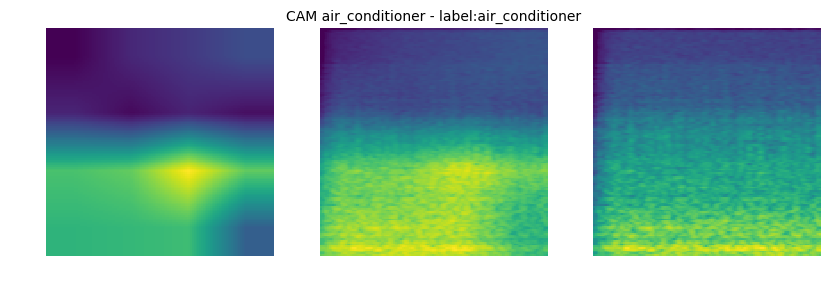

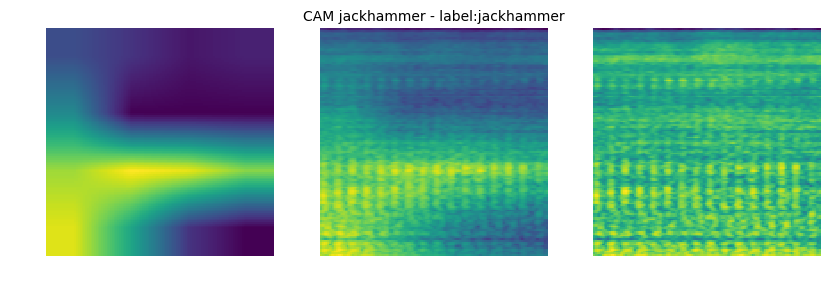

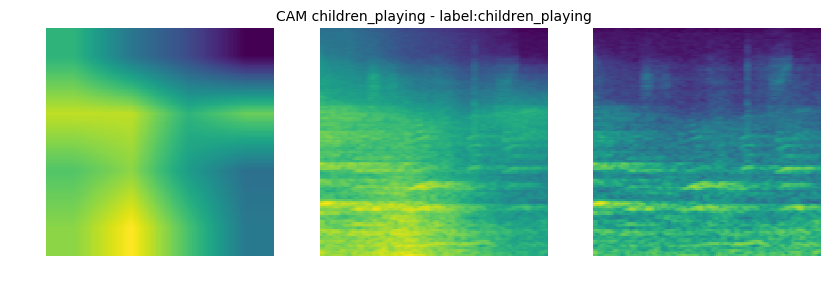

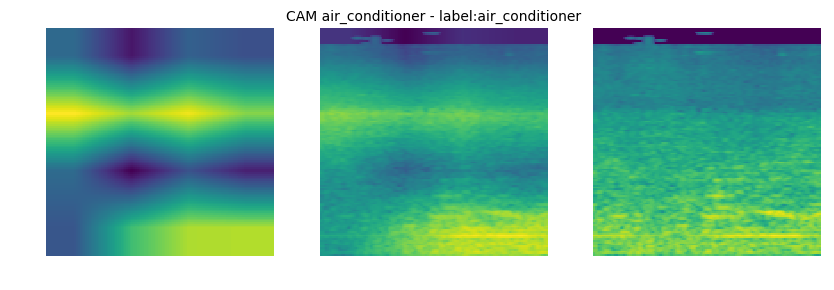

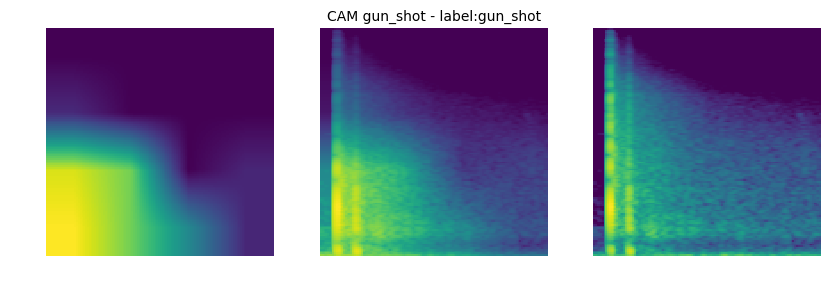

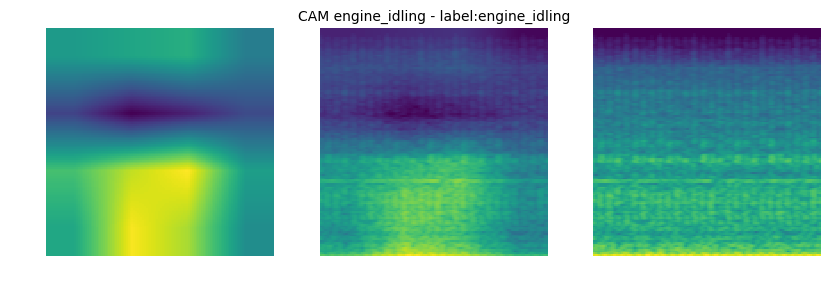

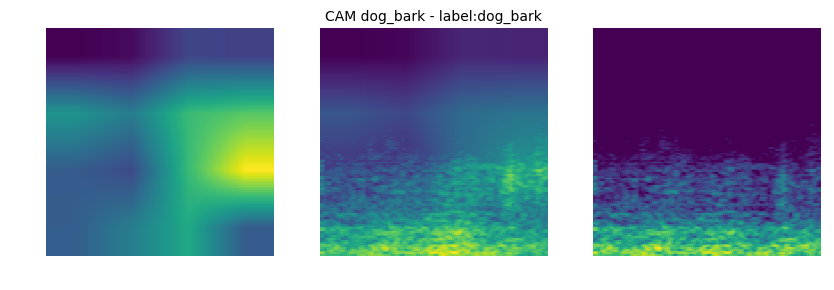

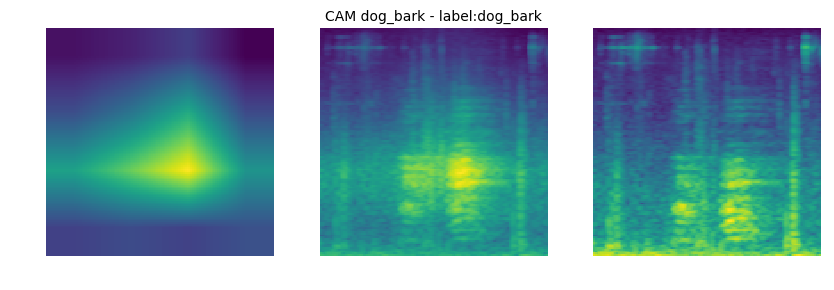

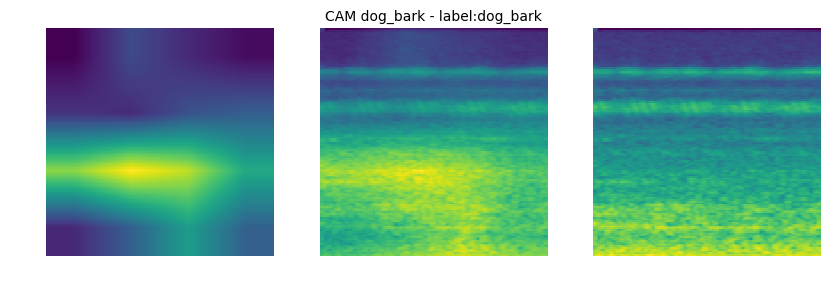

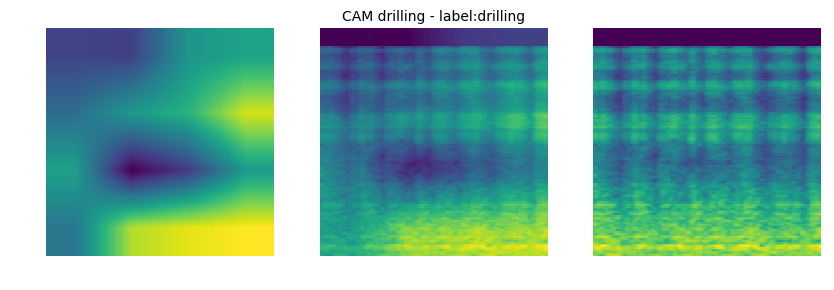

In [17]:
from visualize import visualize_cam_audio
import random

#offset = 0
#for i in range(offset, offset + 100, 10):
for j in range(5):
    i = random.randint(0, len(X_train))
    visualize_cam_audio(conf, model, X_train[offset+i], 'label:{}'.format(conf.labels[np.argmax(y_train[offset+i])]))

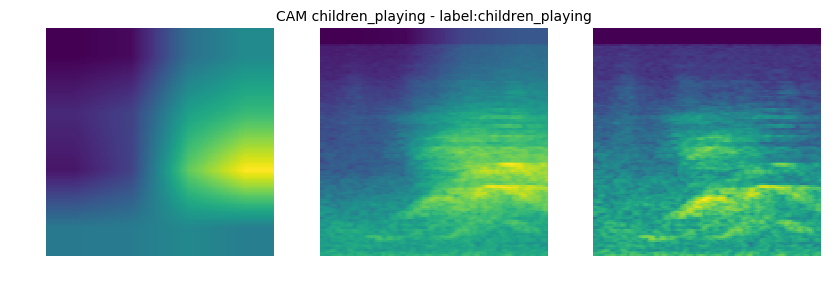

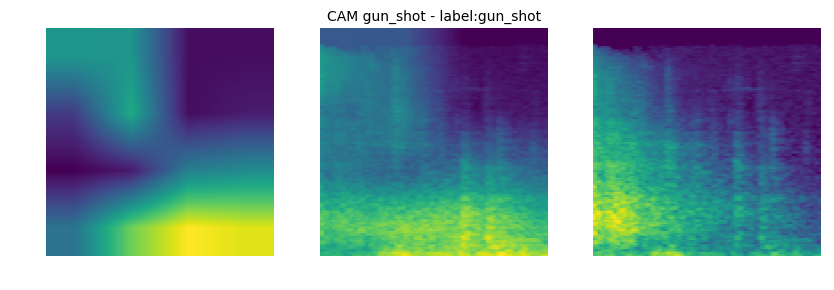

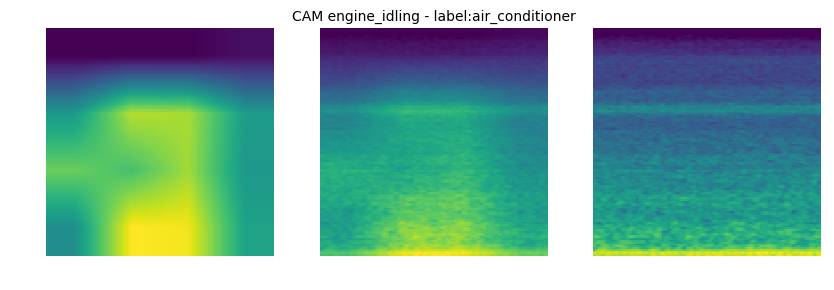

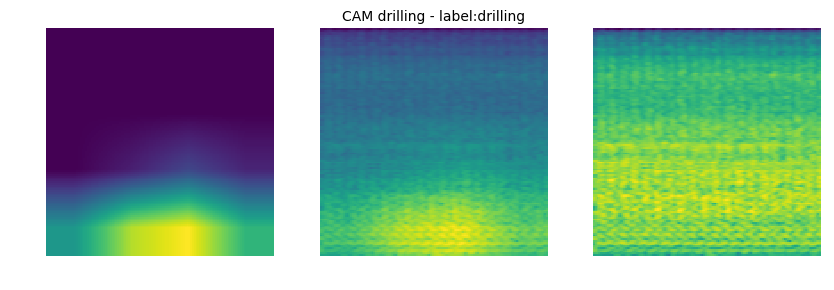

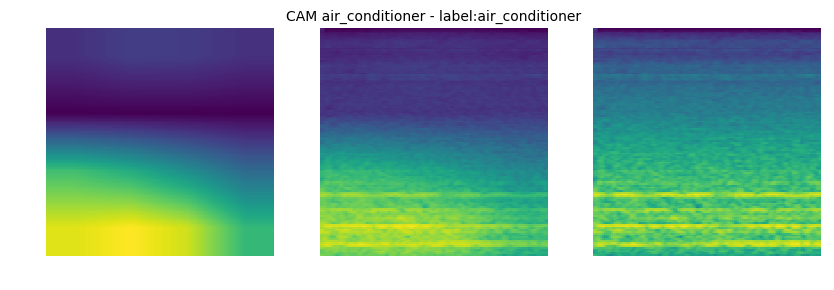

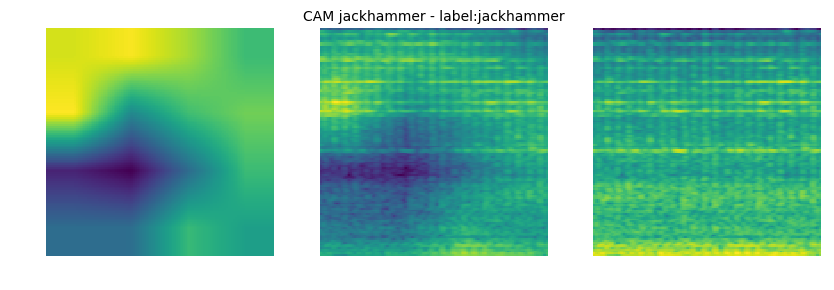

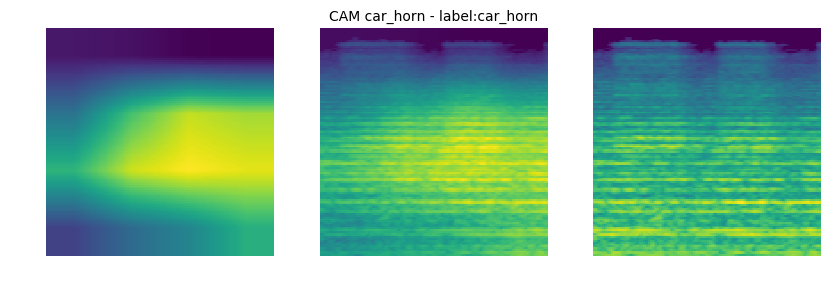

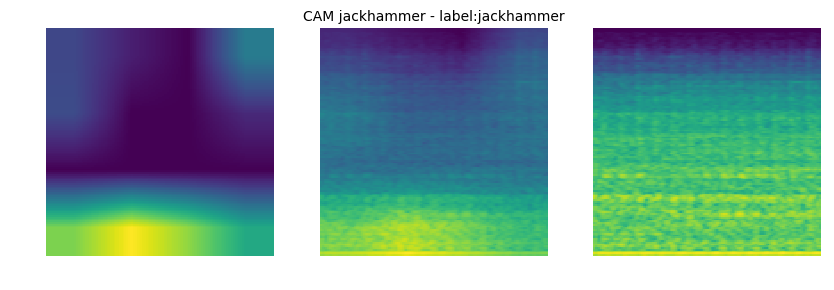

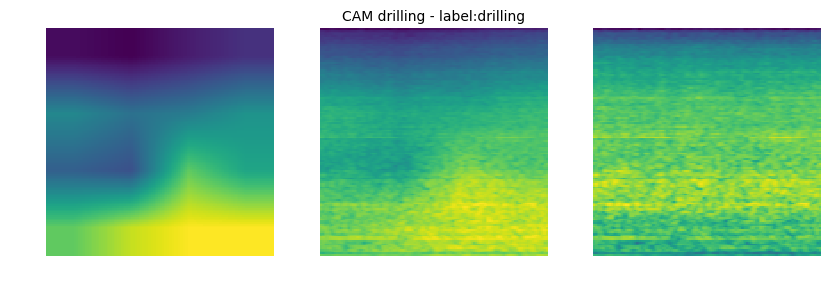

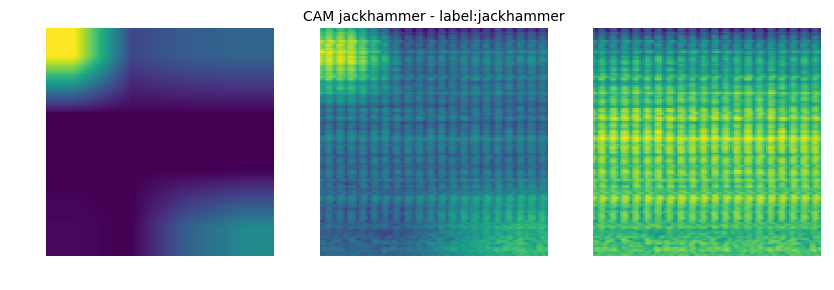

In [29]:
for j in range(5):
    i = random.randint(0, len(X_test))
    visualize_cam_audio(conf, model, X_test[offset+i], 'label:{}'.format(conf.labels[np.argmax(y_test[offset+i])]))